In [50]:
import six
import numpy as np
import datetime
import os
import glob
import matplotlib.pyplot as plt
import logging as log
from stompy import utils
from stompy import memoize
import xarray as xr
from matplotlib import colors
%matplotlib notebook

In [74]:
from stompy.grid import unstructured_grid
six.moves.reload_module(unstructured_grid)
import postprocess_v00 as post
six.moves.reload_module(post)

<module 'postprocess_v00' from '/home/rusty/src/microplastic_sfbay/postprocess/postprocess_v00.py'>

In [42]:
grid_fn="/opt2/sfb_ocean/suntans/runs/merged_018_20171227/ptm_average.nc_0000.nc"  
grid=post.grid_from_ptm_hydro(grid_fn)

In [4]:
M=grid.smooth_matrix(f=0.5,dx='grid',A='grid',V='grid',K='scaled')

INFO:utils:47555/99089
INFO:utils:93999/99089


Process one month chunks
==

In [75]:
out_dir="processed"
os.path.exists(out_dir) or os.makedirs(out_dir)

def process_batch(ptm_runs,
                  time_range,
                  patterns,
                  z_ranges,
                  max_age_days=15,
                  version='v01'):
    time_str=(utils.to_datetime(time_range[0]).strftime('%Y%m%d')
              + '_'
              + utils.to_datetime(time_range[1]).strftime('%Y%m%d'))
    
    for group_name,group_patt in patterns:
        log.info(f"Processing {group_name}, pattern: {group_patt}")
        chunk_dir=os.path.join(out_dir,time_str,group_name)
        os.path.exists(chunk_dir) or os.makedirs(chunk_dir)
  
        # calculated on-demand in the loop below
        @memoize.memoize()
        def parts():
            log.info("Extracting particles")
            result=post.query_runs(ptm_runs,
                                   group_patt=group_patt,
                                      time_range=time_range,
                                      z_range=None, # not ready
                                      max_age=np.timedelta64(max_age_days,'D'),
                                      conc_func=post.conc_func,
                                      grid=grid)
            log.info("Adding vertical info")
            result=post.add_z_info(result,grid,ptm_runs)
            return result
        for z_name,z_range in z_ranges: 
            # Just the particles for the period, with mass, but not filtered
            # on elevation:
            conc_nc_fn=os.path.join(chunk_dir,f'particles-{z_name}-{max_age_days}days-{version}.nc')
            if not os.path.exists(conc_nc_fn):
                log.info(f"writing to {conc_nc_fn}")
                p=parts()
                p=post.filter_by_z_range(p,z_range,grid,ptm_runs)
                conc=post.particle_to_density(p,grid,normalize='area')
                # could also use the z_bed, z_surf values to turn particle mass into
                # a mass/z, such that normalize by area then gives a volume concentration.
                # unless it's full water column, have to do some truncating
                
                # this should preserve most of the metadata
                ds=p.copy()
                particle_vars=[v for v in ds.variables if 'particle' in ds[v].dims]
                for v in particle_vars:
                    del ds[v]
                
                grid.write_to_xarray(ds=ds)
                ds['conc']=('face',),conc
                
                ds.to_netcdf(conc_nc_fn)
                log.info("done writing")

In [71]:
patterns=[
    ('-0.05','.*_down50000'),
    ('-0.005','.*_down5000'),
    ('-0.0005','.*_down500'),
    ('0.0','.*_none'),
    ('0.0005','.*_up500'),
    ('0.005','.*_up5000'),
    ('0.05','.*_up50000')
]

z_ranges=[
    ('bed',[0,0.5]),
    ('surf',[-0.5,0]),
    ('avg',[0,0])
]

In [46]:
# July 2017
ptm_runs=[                                                                                                                                             
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w-0.05"),                                                                                  
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w-0.005"),                                                                                 
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w-0.0005"),                                                                                
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w0.0"),                                                                                 
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w0.0005"),                                                            
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w0.005"),                                                                                  
        post.PtmRun(run_dir="/opt2/sfb_ocean/ptm/all_source/20170615/w0.05"),                                                                                   
]                                                                                                                                                      

# just the time period with a full field for max_age=15D
time_range=[np.datetime64('2017-06-30'),np.datetime64('2017-07-15')]

process_batch(ptm_runs,time_range,patterns,z_ranges=z_ranges)

INFO:root:Processing -0.05, pattern: .*_down50000
INFO:root:Processing -0.005, pattern: .*_down5000
INFO:root:Processing -0.0005, pattern: .*_down500
INFO:root:Processing 0.0, pattern: .*_none
INFO:root:Processing 0.0005, pattern: .*_up500
INFO:root:Processing 0.005, pattern: .*_up5000
INFO:root:Processing 0.05, pattern: .*_up50000


In [49]:
# August 2017
ptm_runs=[ post.PtmRun(run_dir=d) 
          for d in glob.glob("/opt2/sfb_ocean/ptm/all_source/20170715/*") ]
assert len(ptm_runs)==7

# just the time period with a full field for max_age=15D
start=np.datetime64('2017-07-30')

time_range=[start,start+np.timedelta64(15,'D')]
process_batch(ptm_runs,time_range,patterns,z_ranges=z_ranges)

INFO:root:Processing -0.05, pattern: .*_down50000
INFO:root:writing to processed/20170730_20170814/-0.05/particles-bed-15days-v01.nc
INFO:root:Extracting particles
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.05: sunnyvale_down50000
INFO:root:Will skip source sunnyvale, behavior down50000, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.05: src001_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.05: petaluma_down50000
INFO:root:Will skip source petaluma -- it's in skip_source
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.05: src000_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.05: SCLARAVCc_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.05: UALAMEDA_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.05: NAPA_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.05: san_jose_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.05: cccsd_down50000
INFO:root:/o

INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.0005: petaluma_down500
INFO:root:Will skip source petaluma -- it's in skip_source
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.0005: NAPA_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.0005: SacRiver_down500
INFO:root:Will skip source SacRiver, behavior down500, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.0005: src002_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.0005: cccsd_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.0005: COYOTE_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w-0.0005: sunnyvale_down500
INFO:root:Adding vertical info
INFO:UnstructuredGrid:Building point index (6584388 points)
INFO:UnstructuredGrid:Querying point index (57124 cells)
INFO:utils:1713097
INFO:root:done writing
INFO:root:writing to processed/20170730_20170814/-0.0005/particles-surf-15days-v01.nc
INFO:root:done writing
INFO:root:writing to processed/2017

INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: sunnyvale_up5000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: SCLARAVCc_up5000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: src000_up5000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: src001_up5000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: COYOTE_up5000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: UALAMEDA_up5000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: fs_up5000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: NAPA_up5000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: san_jose_up5000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: src002_up5000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: SJRiver_up5000
INFO:root:Will skip source SJRiver, behavior up5000, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20170715/w0.005: petaluma_up5000
INFO:root:Will skip source petaluma -- it's in skip_s

In [76]:
def process_date(run_date):
    """
    run_date: YYYYMMDD string for start of runs
    """
    ptm_runs=[post.PtmRun(run_dir=d) 
              for d in glob.glob(f"/opt2/sfb_ocean/ptm/all_source/{run_date}/*") ]
    assert len(ptm_runs)==7
    
    # just the time period with a full field for max_age=15D
    start=np.timedelta64(15,'D') + utils.to_dt64(datetime.datetime.strptime(run_date,'%Y%m%d'))

    time_range=[start,start+np.timedelta64(15,'D')]
    process_batch(ptm_runs,time_range,patterns,z_ranges=z_ranges)    

In [ ]:
for d in ["20170615",
          "20170715",
          "20170815",
          "20170915",
          "20171015",
          "20171115",
          # "20171215",
          "20180115",
          "20180215",
          "20180315",
          # "20180415"
         ]:
    process_date(d)

INFO:root:Processing -0.05, pattern: .*_down50000
INFO:root:Processing -0.005, pattern: .*_down5000
INFO:root:Processing -0.0005, pattern: .*_down500
INFO:root:Processing 0.0, pattern: .*_none
INFO:root:Processing 0.0005, pattern: .*_up500
INFO:root:Processing 0.005, pattern: .*_up5000
INFO:root:Processing 0.05, pattern: .*_up50000
INFO:root:Processing -0.05, pattern: .*_down50000
INFO:root:Processing -0.005, pattern: .*_down5000
INFO:root:Processing -0.0005, pattern: .*_down500
INFO:root:Processing 0.0, pattern: .*_none
INFO:root:Processing 0.0005, pattern: .*_up500
INFO:root:Processing 0.005, pattern: .*_up5000
INFO:root:Processing 0.05, pattern: .*_up50000
INFO:root:Processing -0.05, pattern: .*_down50000
INFO:root:Processing -0.005, pattern: .*_down5000
INFO:root:Processing -0.0005, pattern: .*_down500
INFO:root:Processing 0.0, pattern: .*_none
INFO:root:Processing 0.0005, pattern: .*_up500
INFO:root:Processing 0.005, pattern: .*_up5000
INFO:root:Processing 0.05, pattern: .*_up5000

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180317/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180506/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w-0.05: petaluma_down50000
INFO:root:Will skip source petaluma -- it's in skip_sou

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170928/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171008/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170819/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180205/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180225/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180307/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180317/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180506/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180205/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180225/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180307/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180317/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170928/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171008/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170928/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171008/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170819/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170928/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171008/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:roo

INFO:root:Will skip source palo_alto, behavior none, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0: cccsd_none
INFO:root:Will skip source cccsd, behavior none, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0: san_jose_none
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170610/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170620/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170630/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/sunta

INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0: NAPA_none
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0: petaluma_none
INFO:root:Will skip source petaluma -- it's in skip_source
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0: src000_none
INFO:root:Will skip source src000, behavior none, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0: SCLARAVCc_none
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0: SacRiver_none
INFO:root:Got SacRiver -- returning 0.0
INFO:root:Will skip source SacRiver, behavior none, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0: UALAMEDA_none
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0: COYOTE_none
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0: src001_none
INFO:root:Will skip source src001, behavior none, its concentration is 0
INFO:root:Adding vertical info
INFO:UnstructuredGrid:Building point index (2743495 points)
INFO:UnstructuredGrid:Querying point i

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180205/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180225/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180307/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180317/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180205/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180317/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180506/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0005: san_jose_up500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180115/w0.0005:

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170928/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171008/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170819/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180205/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180317/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180506/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170610/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180205/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180225/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180307/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180317/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170928/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171008/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171008/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170928/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171008/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:roo

INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: src001_down50000
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170610/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170620/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170630/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_

INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: petaluma_down50000
INFO:root:Will skip source petaluma -- it's in skip_source
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: src000_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: SCLARAVCc_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: UALAMEDA_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: NAPA_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: san_jose_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: cccsd_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: fs_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: SacRiver_down50000
INFO:root:Will skip source SacRiver, behavior down50000, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: src002_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w-0.05: palo_alto_down50000
INFO:root:/opt2/sfb_ocean/ptm

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180205/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180225/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180307/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180317/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180307/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180317/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180506/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170610/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170620/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170630/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180506/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:done writing
INFO:root:writing to processed/20180302_20180317/-0.005/particles-avg-15days-v01.nc
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170610/
INFO:root:Remapping /shar

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180205/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170819/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:roo

INFO:root:Will skip source petaluma -- it's in skip_source
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w0.0: src000_none
INFO:root:Will skip source src000, behavior none, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w0.0: SCLARAVCc_none
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w0.0: SacRiver_none
INFO:root:Will skip source SacRiver, behavior none, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w0.0: UALAMEDA_none
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w0.0: COYOTE_none
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180215/w0.0: src001_none
INFO:root:Will skip source src001, behavior none, its concentration is 0
INFO:root:Adding vertical info
INFO:UnstructuredGrid:Building point index (2743495 points)
INFO:UnstructuredGrid:Querying point index (57124 cells)
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170610/
INFO:root:Remapping /shared2/src/

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180225/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180307/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180317/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180205/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180225/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180307/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180506/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180526/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180605/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170819/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170928/
INFO:roo

INFO:utils:1737748
INFO:root:done writing
INFO:root:writing to processed/20180302_20180317/0.0005/particles-avg-15days-v01.nc
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170610/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170620/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170630/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:r

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180205/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170819/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170928/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170630/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170819/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:done writing
INFO:root:writing to processed/20180302_20180317/0.05/particles-surf-15days-v01.nc
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170610/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170620/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170630/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /share

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180506/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:utils:1779829
INFO:utils:3480174
INFO:utils:5238396
INFO:root:done writing
INFO:root:Processing -0.05, pattern: .*_down50000
INFO:root:writing to processed/20180330_20180414/-0.05/particles-bed-15days-v01.nc
INFO:root:Extracting particles
INFO:root:/o

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.05: petaluma_down50000
INFO:root:Will skip source petaluma -- it's in skip_source
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.05: src000_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.05: SCLARAVCc_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.05: UALAMEDA_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.05: NAPA_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.05: san_jose_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.05: cccsd_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.05: fs_down50000
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.05: SacRiver_down50000
INFO:root:Will skip source SacRiver, behavior down50000, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.05: 

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170620/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170630/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170819/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180106/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180116/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180126/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170819/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180506/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180526/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180605/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180615/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180506/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.0005: palo_alto_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.0005: src000_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.0005: san_jose_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.0005: fs_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.0005: SJRiver_down500
INFO:root:Will skip source SJRiver, behavior down500, its concentration is 0
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.0005: UALAMEDA_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.0005: SCLARAVCc_down500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w-0.0005: petaluma_down500
INFO:root:Will skip source petaluma -- it's in skip_source
INFO:ro

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171008/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:roo

INFO:root:done writing
INFO:root:writing to processed/20180330_20180414/-0.0005/particles-avg-15days-v01.nc
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170610/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170620/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170630/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170809/
INFO:root:Remapping /sha

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171207/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171217/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171227/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170928/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171008/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171107/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171117/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171127/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180625/
INFO:root:done writing
INFO:root:writing to processed/20180330_20180414/0.0/particles-surf-15days-v01.nc
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170610/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170620/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170630/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170710/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170720/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170730/
INFO:root:Remapping /shared

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180215/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180225/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180307/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180317/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180327/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180406/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180416/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180426/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180506/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w0.0005: san_jose_up500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w0.0005: fs_up500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w0.0005: cccsd_up500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w0.0005: palo_alto_up500
INFO:root:/opt2/sfb_ocean/ptm/all_source/20180315/w0.0005: src001_up500
INFO:root:/opt2/sfb_

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170819/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170829/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170908/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170918/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170928/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171008/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171018/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20171028/
INFO:roo

INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180516/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180526/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180605/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180615/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20180625/
INFO:utils:1735717
INFO:root:done writing
INFO:root:writing to processed/20180330_20180414/0.0005/particles-avg-15days-v01.nc
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170610/
INFO:root:Remapping /shared2/src/sfb_ocean/ => /opt2/sfb_ocean/ in /shared2/src/sfb_ocean/suntans/runs/merged_018_20170620/
INFO:r

In [212]:
class BayConcFigure(object):
    figsize=(9,7)
    vmin=1e-6
    vmax=1e-2
    zoom=(517521., 613202., 4139744., 4230105.)
    cax_loc=[0.7,0.25,0.03,0.35]
    num=None
    def __init__(self,conc,**kw):
        utils.set_keywords(self,kw)
                    
        self.fig=plt.figure(figsize=(10,8),num=self.num)
        self.ax=self.fig.add_subplot(1,1,1)
        
        self.ccoll=grid.plot_cells(values=conc.clip(self.vmin,self.vmax),
                                   cmap='jet',norm=colors.LogNorm(vmin=self.vmin,vmax=self.vmax),
                                   edgecolor='face',lw=0.4,ax=self.ax)
        self.cax=self.fig.add_axes(self.cax_loc)
        plt.colorbar(ccoll,cax=self.cax)
        self.ax.set_aspect('equal')
        self.ax.xaxis.set_visible(0)
        self.ax.yaxis.set_visible(0)
        self.ax.axis(self.zoom)
        self.fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01)
        

<IPython.core.display.Javascript object>


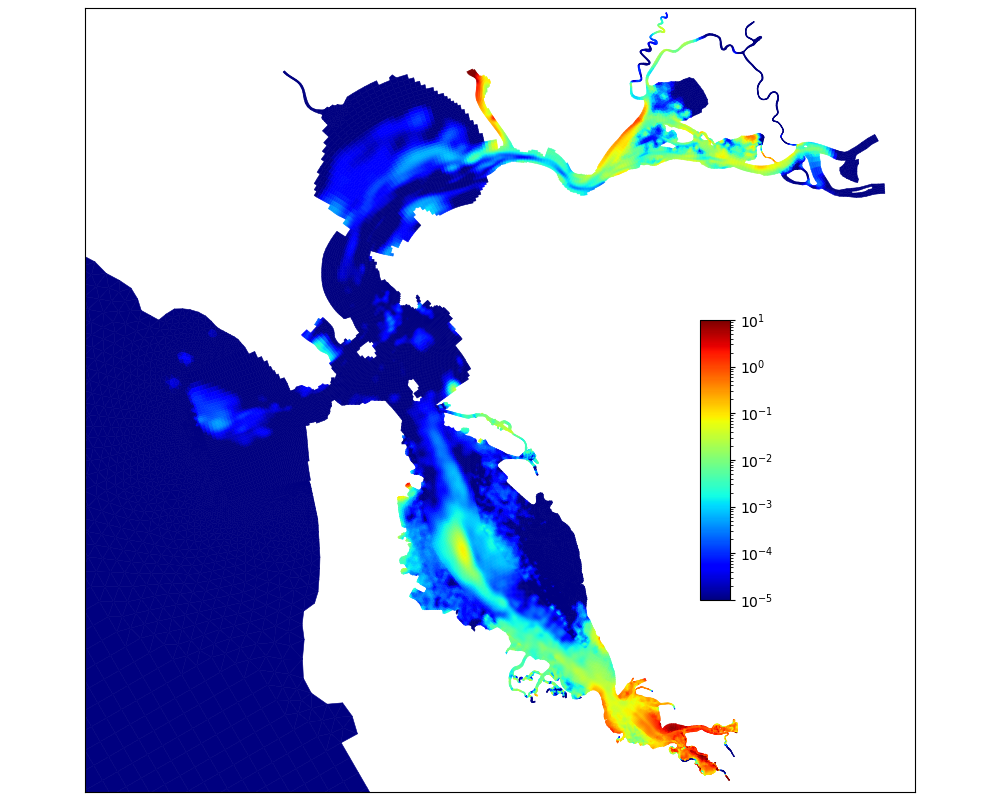

In [213]:
bfig=BayConcFigure(conc24)

<IPython.core.display.Javascript object>


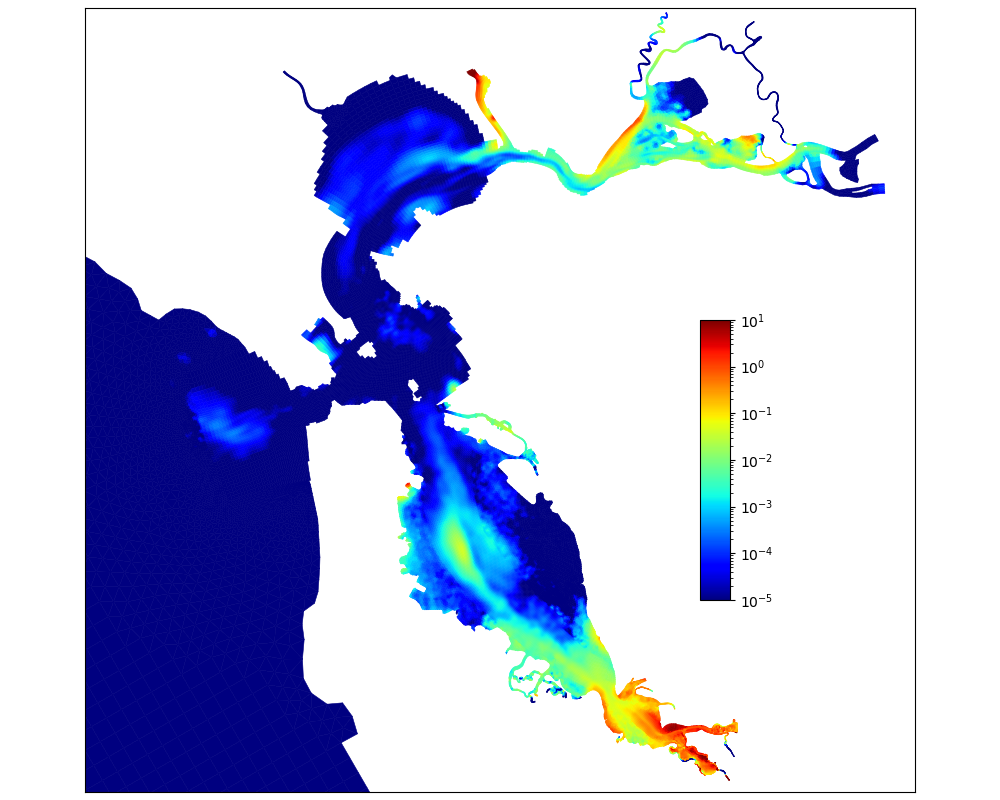

In [214]:
bfig=BayConcFigure(conc48)